# Solve surface volatiles according to outgassing+chemistry

In [1]:
import sys
sys.path.append("..")
from calliope.surface_gases import *
from calliope.structure import calculate_mantle_mass
from calliope.constants import R_earth, const_G, M_earth, dict_colors


import itertools
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from cmcrameri import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
%matplotlib inline

In [2]:
# https://stackoverflow.com/a/65972406
def _ecdf(a):
    a = np.sort(a)
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]


def latexify(s):
    out = ""
    for c in s:
        if c.isdigit():
            out += r"$_%d$"%int(c)
        else:
            out += c
    return out

### Set up initial options dict

In [3]:
OPTIONS = {}

OPTIONS['Phi_global'] = 1.0
OPTIONS['T_magma'] = 3000.0
OPTIONS['radius'] = R_earth * 1.875
OPTIONS['mass']   = M_earth * 7.99
OPTIONS['gravity'] = const_G * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans'] = 8.0
OPTIONS['CH_ratio'] = 1.0
OPTIONS['fO2_shift_IW'] = 0.0
OPTIONS['nitrogen_ppmw'] = 2.0
OPTIONS['sulfur_ppmw'] = 235.0
OPTIONS['planet_coresize'] = 0.55

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1

OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])

Gravity = 22.569 m.s-2


### Calculate total amount of each element in the system

In [4]:
OPTIONS["M_mantle"] = calculate_mantle_mass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

In [5]:
solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 6.9844522890625e+19, 'S': 8.206731439648437e+21}


### Parameter grid

In [6]:
indep_vars = {
    "fO2_shift_IW":             np.linspace(-4,   6,    16),
    "CH_ratio":                 np.logspace(-2,   0,    16),
    "hydrogen_earth_oceans":    np.logspace(0,    2,    16),
}
var_props = {
    "fO2_shift_IW":         {"log":False, "label":r"log($f$O$_2$) - IW"},
    "CH_ratio":             {"log":True,  "label":r"C/H"},
    "hydrogen_earth_oceans":{"log":False, "label":r"[H] oceans"},
    "T_magma":              {"log":False, "label":r"T$_\text{magma}$ [K]"},

    "P_surf":               {"log":True,  "label":r"P$_\text{surf}$ [bar]"},
}
volatile_colors = {

}

In [7]:
# convert to floats
for k in indep_vars.keys():
    indep_vars[k] = np.array(indep_vars[k], dtype=float)

# flatten the parameter grid
keys, values = zip(*indep_vars.items())
all_pts = [dict(zip(keys, v)) for v in itertools.product(*values)]
npts = len(all_pts)
print("Total points = %d"%npts)

# loop over points
for i in range(npts):
    if (i+1)%5 == 0:
        print("    i = %3d / %3d = %4.1f%%"%(i+1,npts,100*(i+1)/npts))

    # get base params
    OPTIONS = deepcopy(BACKUP_options)

    # set params at this point
    p = all_pts[i]
    for k in p.keys():
        OPTIONS[k] = p[k]

    # solve
    solvevol_target = get_target_from_params(OPTIONS)
    p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)

    # store
    for k in p_d.keys():
        all_pts[i][k] = p_d[k]


Total points = 4096


/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:91: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/solubility.py:151: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/solubility.py:19: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/solubility.py:124: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/solubility.py:139: RuntimeWarning: overflow encountered in exp
  ppmw = p*np.exp(4.93 - (0.000193 * p_total))
/dataserver/users/formingworlds/nicholls/CALLIOPE/src/c

    i =   5 / 4096 =  0.1%
    i =  10 / 4096 =  0.2%
    i =  15 / 4096 =  0.4%
    i =  20 / 4096 =  0.5%


/dataserver/users/formingworlds/nicholls/CALLIOPE/src/calliope/surface_gases.py:205: RuntimeWarning: overflow encountered in scalar multiply
  mass_int_d['N2'] = prefactor*ppmw_N2


    i =  25 / 4096 =  0.6%
    i =  30 / 4096 =  0.7%
    i =  35 / 4096 =  0.9%
    i =  40 / 4096 =  1.0%
    i =  45 / 4096 =  1.1%
    i =  50 / 4096 =  1.2%
    i =  55 / 4096 =  1.3%
    i =  60 / 4096 =  1.5%
    i =  65 / 4096 =  1.6%
    i =  70 / 4096 =  1.7%
    i =  75 / 4096 =  1.8%
    i =  80 / 4096 =  2.0%
    i =  85 / 4096 =  2.1%
    i =  90 / 4096 =  2.2%
    i =  95 / 4096 =  2.3%
    i = 100 / 4096 =  2.4%
    i = 105 / 4096 =  2.6%
    i = 110 / 4096 =  2.7%
    i = 115 / 4096 =  2.8%
    i = 120 / 4096 =  2.9%
    i = 125 / 4096 =  3.1%
    i = 130 / 4096 =  3.2%
    i = 135 / 4096 =  3.3%
    i = 140 / 4096 =  3.4%
    i = 145 / 4096 =  3.5%
    i = 150 / 4096 =  3.7%
    i = 155 / 4096 =  3.8%
    i = 160 / 4096 =  3.9%
    i = 165 / 4096 =  4.0%
    i = 170 / 4096 =  4.2%
    i = 175 / 4096 =  4.3%
    i = 180 / 4096 =  4.4%
    i = 185 / 4096 =  4.5%
    i = 190 / 4096 =  4.6%
    i = 195 / 4096 =  4.8%
    i = 200 / 4096 =  4.9%
    i = 205 / 4096 =  5.0%
 

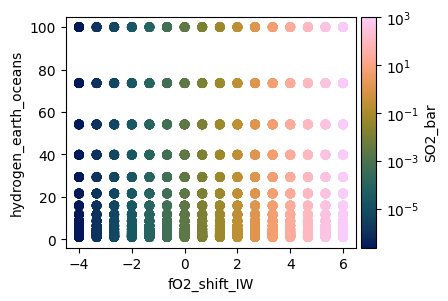

In [8]:
# plot scatter
plt.close("all")

x_key = "fO2_shift_IW"
y_key = "hydrogen_earth_oceans"
z_key = "SO2_bar"

x_arr, y_arr, z_arr = [], [], []
for i in range(npts):
    x_arr.append(all_pts[i][x_key])
    y_arr.append(all_pts[i][y_key])
    z_arr.append(all_pts[i][z_key])

fig,ax = plt.subplots(1,1, figsize=(4,3))

divider = make_axes_locatable(ax)
cmap = cm.batlow
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.LogNorm(vmin=np.amin(z_arr), vmax=np.amax(z_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(z_key)

ax.scatter(x_arr, y_arr, c=z_arr, cmap=cmap, norm=norm)

ax.set(xlabel=x_key, ylabel=y_key)

plt.show()


### Plot ECDFs

In [9]:
# invert parameter grid based on all keys...

def invert_result(_dep_keys):
    result = {}
    for k in indep_vars.keys():
        result[k] = []
    for k in _dep_keys:
        result[k] = []

    for i in range(npts):
        for k in indep_vars.keys():
            result[k].append(all_pts[i][k])
        for k in _dep_keys:
            val = all_pts[i][k]
            if "vmr" in k:
                val *= 100
            result[k].append(val)

    return result

def result_as_df(result):
    df = pd.DataFrame.from_dict(result, dtype=float)
    df.to_csv("nogit_solvevol.tsv", sep='\t', float_format="%.6e", index=False)
    return df

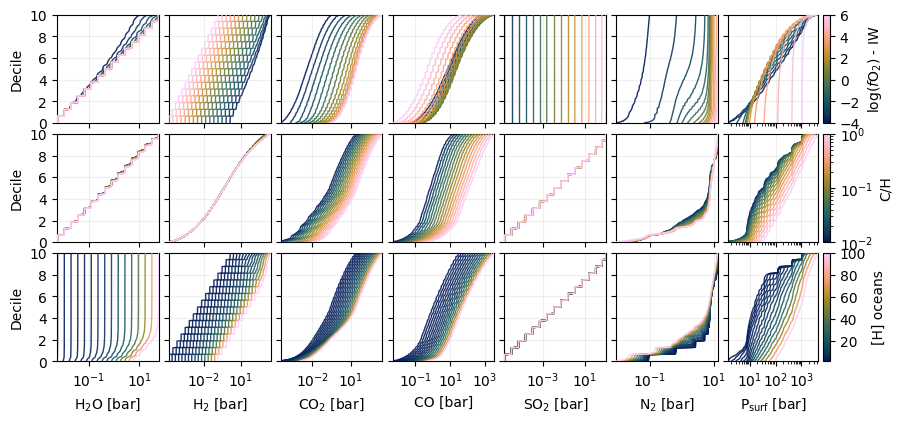

In [10]:
dep_keys = ["H2O_bar", "H2_bar", "CO2_bar", "CO_bar", "SO2_bar", "N2_bar", "P_surf"]
result = invert_result(dep_keys)
df = result_as_df(result)


# create figure
cmap = cm.batlow
ndep = len(dep_keys)
nind = len(indep_vars)

lw=1.0
al=0.9

scale = 1.5
fig,axs = plt.subplots(nind, ndep, figsize=(ndep*scale*0.95, nind*scale))

# for each independent variable...
for i,k in enumerate(indep_vars.keys()):

    # create cbar
    divider = make_axes_locatable(axs[i,-1])
    cax = divider.append_axes('right', size="8%", pad=0.05)
    cbar_min, cbar_max = np.amin(indep_vars[k]), np.amax(indep_vars[k])
    if var_props[k]["log"]:
        norm = mpl.colors.LogNorm(vmin=cbar_min, vmax=cbar_max)
        locator = ticker.LogLocator(base=10, numticks=5)
    else:
        norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)
        locator = ticker.MaxNLocator(5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.ax.yaxis.set_major_locator(locator)
    cbar.set_label(var_props[k]["label"])

    # for each value of that variable...
    for j,v in enumerate(indep_vars[k]):

        # for all dep variables at this slice of indep vars
        for idx_dep, kk in enumerate(dep_keys):
            subset_y = []
            for ir,r in enumerate(result[k]):
                if np.isclose(r, v):
                    subset_y.append(result[kk][ir])
            dist_x, dist_y = _ecdf(subset_y)
            axs[i,idx_dep].plot(dist_x, dist_y*10, c=sm.to_rgba(v), zorder=j, lw=lw, alpha=al)


# decorate
for i in range(ndep):

    kdep = dep_keys[i]
    xscale = "linear"
    if kdep in var_props.keys():
        if var_props[kdep]["log"]:
            xscale = "log"
        axs[-1,i].set_xlabel(var_props[kdep]["label"])
    else:
        axs[-1,i].set_xlabel(kdep)
        if "bar" in kdep:
            xscale="log"

    for j in range(nind):
        axs[j,i].grid(zorder=-3, alpha=0.2)
        axs[j,i].set_zorder(99)
        axs[j,i].set_xscale(xscale)
        axs[j,i].set_yticks([0, 2, 4, 6, 8, 10])
        axs[j,i].set_ylim(top=10, bottom=0)
        axs[j,0].set_ylabel("Decile")

        if "vmr" in kdep:
            axs[j,i].set_xlim(left=0, right=100)
            axs[j,i].set_xticks([0, 25, 50, 75])
            axs[-1,i].set_xlabel(latexify(kdep.split("_")[0])+" VMR %")
        else:
            if xscale=="log":
                locator = ticker.LogLocator(base=10, numticks=3)
            else:
                locator = ticker.MaxNLocator(numticks=3)

            axs[j,i].xaxis.set_major_locator(locator)

            if "bar" in kdep:
                axs[-1,i].set_xlabel(latexify(kdep.split("_")[0])+" [bar]")
            axs[j,i].set_xlim(left=np.amin(result[dep_keys[i]]), right=np.amax(result[dep_keys[i]]))

        if i > 0:
            axs[j,i].set_yticklabels([])
        if j < nind-1:
            axs[j,i].set_xticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()
fig.savefig("nogit_solvevol_ecdfs.pdf", bbox_inches='tight')

### Pie charts

In [11]:
x_key = "fO2_shift_IW"
y_key = "CH_ratio"


print(indep_vars["hydrogen_earth_oceans"])
controls = {
    "hydrogen_earth_oceans" : indep_vars["hydrogen_earth_oceans"][-1]
}

dep_keys = [v+"_vmr" for v in solvevol_vols]
dep_keys.append("P_surf")
result = invert_result(dep_keys)
df = result_as_df(result)

[  1.           1.35935639   1.8478498    2.51188643   3.41454887
   4.64158883   6.30957344   8.57695899  11.65914401  15.84893192
  21.5443469   29.28644565  39.81071706  54.11695265  73.56422545
 100.        ]


Control variable 'hydrogen_earth_oceans' = 100


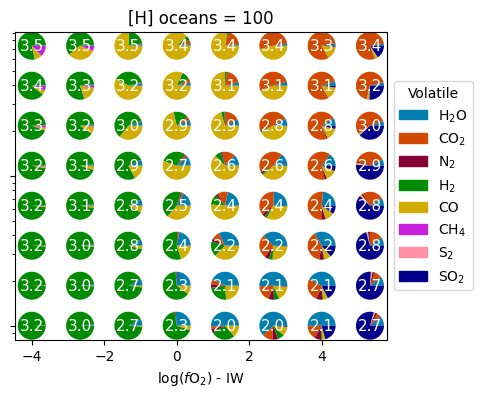

In [12]:
scale = 0.8
fig,ax = plt.subplots(1,1, figsize=(6*scale,5*scale))

downsample_x = 2
downsample_y = 2
ps= 0.35

right_plot = True

title = ""
for k in controls.keys():
    print("Control variable '%s' = %g"%(k, controls[k]))
    title += "%s = %.0f"%(var_props[k]["label"], controls[k])

x_arr = indep_vars[x_key][::downsample_x]
y_arr = indep_vars[y_key][::downsample_y]

# dummy scatter plot
for i,x_val in enumerate(x_arr):
    for j,y_val in enumerate(y_arr):
        ax.scatter(x_val, y_val, c='white')

plotted_combinations = []
for i,x_val in enumerate(x_arr):
    for j,y_val in enumerate(y_arr):

        # check duplicate combinations
        comb_set = {x_val, y_val}
        if comb_set in plotted_combinations:
            continue
        plotted_combinations.append(comb_set)

        # find point on x,y axes
        subset = df.loc[(df[x_key] == x_val) & (df[y_key] == y_val)]

        # apply control variables
        for k in controls.keys():
            subset = subset.loc[subset[k] == controls[k]]
        if len(subset) > 1:
            print("WARNING: degenerate pie chart")
        if len(subset) < 1:
            print("WARNING: empty pie chart")
        p_surf = np.log10(float(subset["P_surf"].iloc[0]))

        # get data as arr
        data = []
        cols = []
        for v in solvevol_vols:
            data.append(float(subset[v+"_vmr"].iloc[0]))
            cols.append(dict_colors[v])

        # plot pie chart
        ax_sub= inset_axes(ax, width=ps, height=ps, loc="center",
                    bbox_to_anchor=(x_val, y_val),
                    bbox_transform=ax.transData,
                    borderpad=0)
        wedges,texts= ax_sub.pie(data, colors=cols)

        # move pie chart weges onto base plot
        # https://stackoverflow.com/a/56935492
        for p in wedges:
            p.remove()
            ax.add_patch(p)
            p.set_zorder(2)
            p.set_clip_on(True)

        # plot text
        ax.text(x_val, y_val, "%.1f"%p_surf, color="white",
                        horizontalalignment="center", verticalalignment="center",
                        fontsize=11, zorder=9)

# decorate
ax.set_xlabel(var_props[x_key]["label"])
if var_props[x_key]["log"]:
    ax.set_xscale("log")
ax.set_ylabel(var_props[y_key]["label"])
if var_props[y_key]["log"]:
    ax.set_yscale("log")
ax.set_title(title)

if right_plot:
    ax.set_yticklabels([])
    ax.set_ylabel("")

    patches = []
    for j,v in enumerate(solvevol_vols):
        patches.append(mpatches.Patch(color=dict_colors[v], label=latexify(v)))
    leg = ax.legend(handles=patches,loc='center left', bbox_to_anchor=(1, 0.5), title="Volatile",fancybox=True)

plt.show()
fig.savefig("nogit_solvevol_pies.pdf", bbox_inches='tight')